In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, r2_score

Importing plotly failed. Interactive plots will not work.


# PreProcessing

In [3]:
def preprocess_cumulative_data(freq='d'):
    # --- 1. Load the Data ---
    file_path = "../data/og_data/Energie_kWh_15_min.csv"
    df = pd.read_csv(
        file_path,
        delimiter=";",
        parse_dates=["timestamp"],
        dayfirst=True,
        na_values="NULL"
    )
    print("✅ Cumulative file loaded!")
    
    # --- 2. Process the Data ---
    df_processed = df.copy()
    numeric_cols = df.columns.drop("timestamp")
    for col in numeric_cols:
        df_processed[col] = df_processed[col].diff()
        df_processed[col] = df_processed[col].apply(lambda x: x if 0 <= x <= 200 else 0)
        df_processed[col] = df_processed[col].fillna(0)
    
    # --- 3. Aggregate by the given frequency ---
    df_processed = df_processed.set_index("timestamp")
    df_agg = df_processed.resample(freq).sum().reset_index()
    print(f"✅ Data aggregated to frequency '{freq}'")
    return df_agg

In [4]:
def preprocess_regressor(freq='d'):
    """
    Load and preprocess the frequency data. Renames columns, orders them,
    interpolates missing values, and selects 'Toevoer toren 1' as the regressor.
    Returns DataFrame with ['timestamp', 'frequentie'].
    """
    file_path = "../data/og_data/frequentie.csv"
    df = pd.read_csv(
        file_path,
        delimiter=";",
        parse_dates=["interval_15min"],
        dayfirst=True,
        na_values="NULL"
    )

    # Rename columns to human-readable format
    col_mapping = {
        'interval_15min':       'timestamp',
        'v_19':                 'Toevoer toren 1',
        'v_84':                 'Afvoer toren 1',
        'v_260':                'Toevoer toren 3',
        'v_261':                'Afvoer toren 3',
        'v_287':                'Toevoer toren 2',
        'v_472':                'Afvoer toren 2',
        'v_595':                'Afvoer toren 4',
        'v_685':                'Toevoer toren 5',
        'v_819':                'Afvoer toren 5',
        'v_835':                'Toevoer toren 4',
        'v_984':                'Toevoer toren 6',
        'v_1111':               'Afvoer toren 6',
        'v_1203':               'Toevoer toren 7',
        'v_1216':               'Afvoer toren 7',
        'v_1320':               'Toevoer toren 8',
        'v_1329':               'Toevoer bijgebouw',
        'v_1550':               'Afvoer toren 8',
        'v_1631':               'Afvoer bijgebouw',
        'v_1676':               'Toevoer vergadercentrum',
        'v_1678':               'Afvoer vergadercentrum',
        'v_1988':               'Afvoer auditorium',
        'v_2069':               'Afvoer 1 keuken',
        'v_2111':               'Toevoer auditorium',
        'v_2168':               'Afvoer 2 keuken',
        'v_2209':               'Toevoer keuken'
    }
    df = df.rename(columns=col_mapping)

    # Reorder columns to match expected layout
    desired_order = [
        'timestamp',
        'Toevoer toren 1',
        'Afvoer toren 1',
        'Afvoer toren 3',
        'Toevoer toren 2',
        'Afvoer toren 2',
        'Toevoer toren 3',
        'Afvoer toren 4',
        'Toevoer toren 5',
        'Afvoer toren 5',
        'Toevoer toren 4',
        'Toevoer toren 7',
        'Toevoer toren 6',
        'Afvoer toren 6',
        'Afvoer toren 7',
        'Afvoer toren 8',
        'Toevoer toren 8',
        'Toevoer bijgebouw',
        'Afvoer bijgebouw',
        'Afvoer vergadercentrum',
        'Toevoer vergadercentrum',
        'Afvoer 1 keuken',
        'Toevoer auditorium',
        'Afvoer auditorium',
        'Toevoer keuken',
        'Afvoer 2 keuken'
    ]
    df = df[desired_order]

    # Interpolate and align with frequency
    df = (
        df.drop_duplicates(subset="timestamp")
          .set_index("timestamp")
          .asfreq(freq)
          .interpolate()
          .reset_index()
    )
    df["timestamp"] = df["timestamp"].dt.normalize()

    # Use 'Toevoer toren 1' as regressor
    df = df.rename(columns={'Toevoer toren 1': 'frequentie'})
    print(f"✅ Regressor data loaded and aligned to frequency '{freq}' using 'Toevoer toren 1'")
    return df[['timestamp', 'frequentie']]

In [5]:
def forecast_kwh(freq='d',
                 train_start=None,
                 train_end="2024-06-04",
                 test_start="2024-06-05",
                 test_end=None):
    # 1) Load & aggregate
    df = preprocess_cumulative_data(freq=freq)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp').asfreq(freq).interpolate().reset_index()
    reg = preprocess_regressor(freq=freq)

    # 2) Identify series, skipping 'Afvoer toren 5'
    afvoer_cols  = [c for c in df.columns if c.startswith('Afvoer') and c != 'Afvoer toren 5']
    toevoer_cols = [c for c in df.columns if c.startswith('Toevoer')]

    # 3) Static train/test bounds
    train_end   = pd.to_datetime(train_end)
    test_start  = pd.to_datetime(test_start)
    test_end    = pd.to_datetime(test_end) if test_end else df['timestamp'].max()

    # 4) Prepare plot grid
    n_rows = max(len(afvoer_cols), len(toevoer_cols))
    fig, axs = plt.subplots(n_rows, 2, figsize=(12, 4*n_rows))
    if n_rows == 1:
        axs = axs[np.newaxis, :]

    results = []  # (col, mae, mae_pct, r2, baseline)

    def fit_one(col, ax, label):
        # merge in regressor
        data = (
            df[['timestamp', col]]
              .rename(columns={'timestamp':'ds', col:'y'})
              .merge(reg, left_on='ds', right_on='timestamp', how='left')
              .drop(columns='timestamp')
        )

        # drop leading zeros/NaNs and find first valid ds
        mask = data['y'].notna() & (data['y'] != 0)
        if not mask.any():
            ax.axis('off')
            return
        first_ds = data.loc[mask, 'ds'].iloc[0]
        data = data[data['ds'] >= first_ds]

        # limit to test_end, fill regressor
        data = data[data['ds'] <= test_end]
        data['frequentie'] = data['frequentie'].ffill().bfill().fillna(0)

        if data['y'].nunique() <= 1:
            ax.axis('off')
            return

        # determine series‐specific train_start
        start = pd.to_datetime(train_start) if train_start is not None else first_ds

        # compute baseline from first-year of training
        baseline_start = start
        baseline_end   = baseline_start + pd.DateOffset(years=1)
        baseline_vals  = data[(data['ds'] >= baseline_start) & (data['ds'] < baseline_end)]['y']
        baseline_mean  = baseline_vals.mean() if not baseline_vals.empty else np.nan

        # split train/test
        train = data[(data['ds'] >= start) & (data['ds'] <= train_end)]
        test  = data[data['ds'] >= test_start]
        if train.empty or test.empty:
            ax.axis('off')
            return

        # fit Prophet
        m = Prophet(
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=True
        )
        m.add_regressor('frequentie')
        m.fit(train)

        # make future & predict
        future = m.make_future_dataframe(periods=len(test), freq=freq)
        future = future.merge(
            data[['ds','frequentie']], on='ds', how='left'
        ).ffill().bfill()
        fcst = m.predict(future)

        # clip at zero
        for c in ['yhat','yhat_lower','yhat_upper']:
            fcst[c] = fcst[c].clip(lower=0)

        # metrics
        y_pred  = fcst.loc[fcst['ds'].isin(test['ds']), 'yhat'].values
        y_true  = test['y'].values
        mae     = mean_absolute_error(y_true, y_pred)
        mae_pct = mae / np.mean(y_true) * 100
        r2      = r2_score(y_true, y_pred)
        results.append((col, mae, mae_pct, r2, baseline_mean))

        # plot forecast
        m.plot(fcst, ax=ax)
        # overlay baseline mean
        ax.axhline(baseline_mean, linestyle='--', label='Baseline Mean')
        ax.set_title(f"{col} ({label}) — MAE: {mae:.2f} ({mae_pct:.1f}%), R²: {r2:.2f}")
        ax.legend()

    # 5) Loop series
    for i in range(n_rows):
        if i < len(afvoer_cols):
            fit_one(afvoer_cols[i], axs[i,0], 'Afvoer')
        else:
            axs[i,0].axis('off')
        if i < len(toevoer_cols):
            fit_one(toevoer_cols[i], axs[i,1], 'Toevoer')
        else:
            axs[i,1].axis('off')

    plt.tight_layout()
    plt.show()

    # 6) Summary
    if results:
        avg_mae     = np.mean([m for _, m, _, _, _ in results])
        avg_mae_pct = np.mean([p for _, _, p, _, _ in results])
        avg_r2      = np.mean([r for _, _, _, r, _ in results])
        avg_base    = np.nanmean([b for _, _, _, _, b in results])

        print("\nForecast Results:")
        for col, mae, pct, r2, base in results:
            print(f"  {col}: Baseline={base:.2f}, MAE={mae:.2f} ({pct:.1f}%), R²={r2:.2f}")
        print(f"\nAverage Baseline: {avg_base:.2f}, Average MAE: {avg_mae:.2f} ({avg_mae_pct:.1f}%), Average R²: {avg_r2:.2f}")
    else:
        print("No series were modeled (all skipped).")

# Daily Prophet

✅ Cumulative file loaded!
✅ Data aggregated to frequency 'd'


16:14:48 - cmdstanpy - INFO - Chain [1] start processing


✅ Regressor data loaded and aligned to frequency 'd' using 'Toevoer toren 1'


16:14:48 - cmdstanpy - INFO - Chain [1] done processing
16:14:48 - cmdstanpy - INFO - Chain [1] start processing
16:14:48 - cmdstanpy - INFO - Chain [1] done processing
16:14:49 - cmdstanpy - INFO - Chain [1] start processing
16:14:49 - cmdstanpy - INFO - Chain [1] done processing
16:14:49 - cmdstanpy - INFO - Chain [1] start processing
16:14:49 - cmdstanpy - INFO - Chain [1] done processing
16:14:49 - cmdstanpy - INFO - Chain [1] start processing
16:14:49 - cmdstanpy - INFO - Chain [1] done processing
16:14:50 - cmdstanpy - INFO - Chain [1] start processing
16:14:50 - cmdstanpy - INFO - Chain [1] done processing
16:14:50 - cmdstanpy - INFO - Chain [1] start processing
16:14:50 - cmdstanpy - INFO - Chain [1] done processing
16:14:50 - cmdstanpy - INFO - Chain [1] start processing
16:14:50 - cmdstanpy - INFO - Chain [1] done processing
16:14:50 - cmdstanpy - INFO - Chain [1] start processing
16:14:50 - cmdstanpy - INFO - Chain [1] done processing
16:14:51 - cmdstanpy - INFO - Chain [1] 

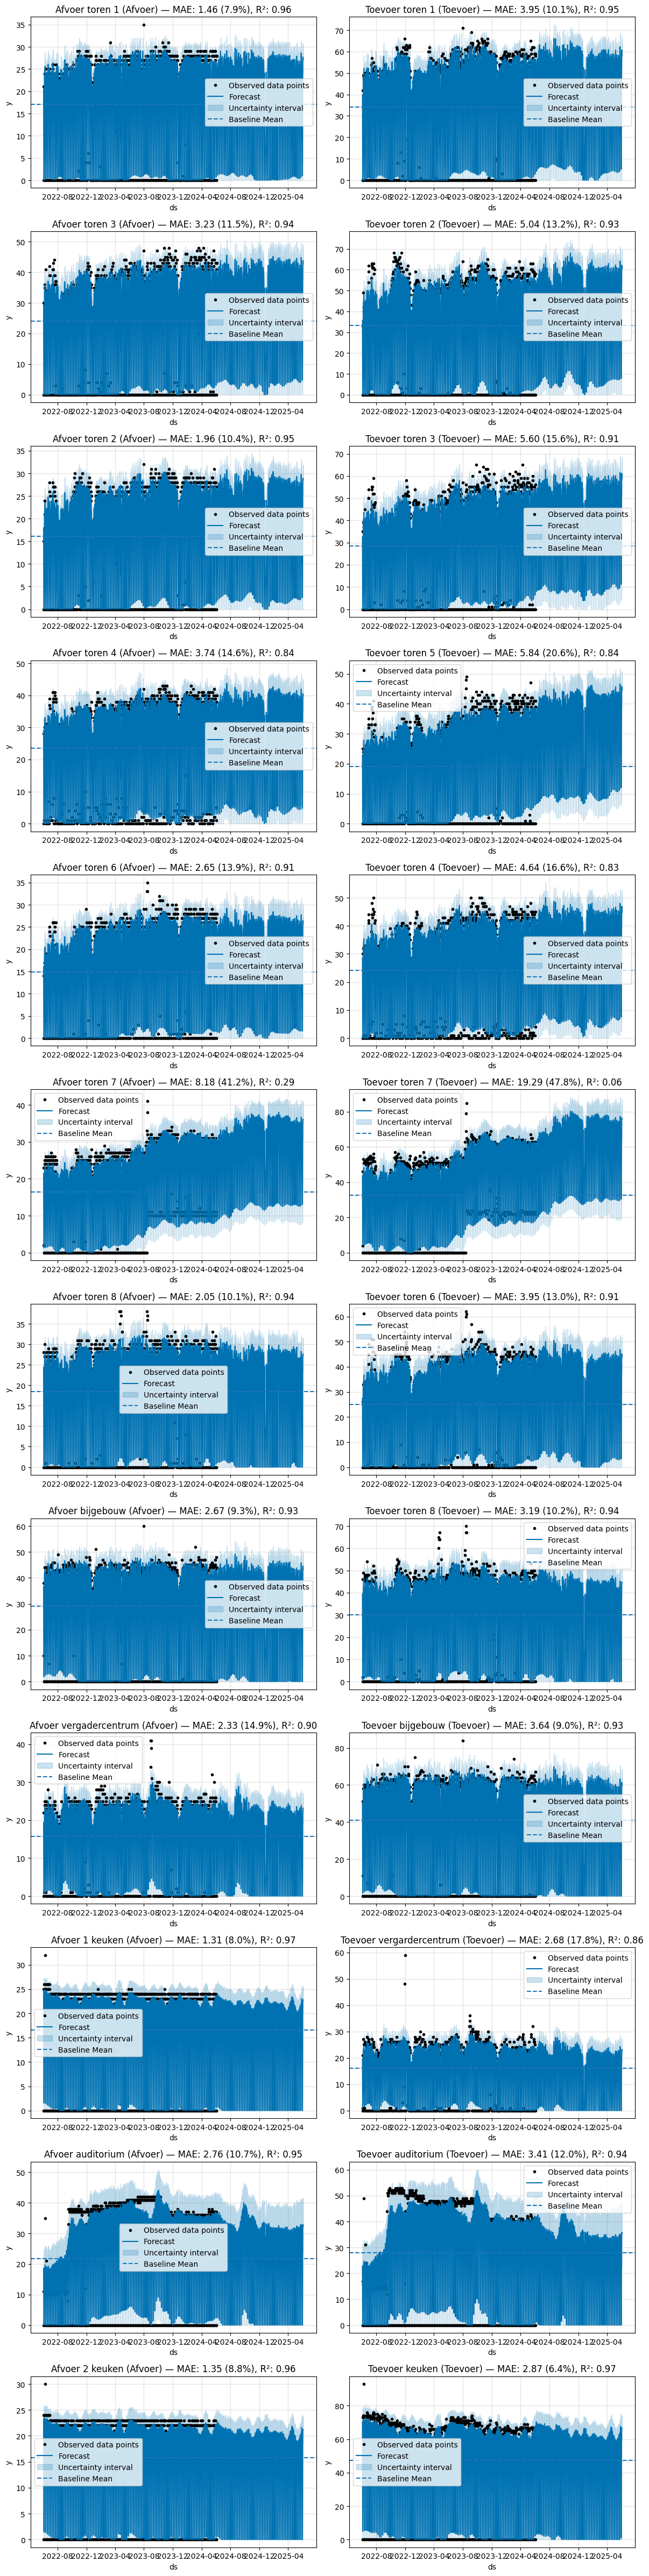


Forecast Results:
  Afvoer toren 1: Baseline=17.10, MAE=1.46 (7.9%), R²=0.96
  Toevoer toren 1: Baseline=34.25, MAE=3.95 (10.1%), R²=0.95
  Afvoer toren 3: Baseline=24.09, MAE=3.23 (11.5%), R²=0.94
  Toevoer toren 2: Baseline=33.17, MAE=5.04 (13.2%), R²=0.93
  Afvoer toren 2: Baseline=16.05, MAE=1.96 (10.4%), R²=0.95
  Toevoer toren 3: Baseline=28.42, MAE=5.60 (15.6%), R²=0.91
  Afvoer toren 4: Baseline=23.45, MAE=3.74 (14.6%), R²=0.84
  Toevoer toren 5: Baseline=19.04, MAE=5.84 (20.6%), R²=0.84
  Afvoer toren 6: Baseline=14.90, MAE=2.65 (13.9%), R²=0.91
  Toevoer toren 4: Baseline=24.15, MAE=4.64 (16.6%), R²=0.83
  Afvoer toren 7: Baseline=16.39, MAE=8.18 (41.2%), R²=0.29
  Toevoer toren 7: Baseline=32.74, MAE=19.29 (47.8%), R²=0.06
  Afvoer toren 8: Baseline=18.46, MAE=2.05 (10.1%), R²=0.94
  Toevoer toren 6: Baseline=24.97, MAE=3.95 (13.0%), R²=0.91
  Afvoer bijgebouw: Baseline=29.01, MAE=2.67 (9.3%), R²=0.93
  Toevoer toren 8: Baseline=30.10, MAE=3.19 (10.2%), R²=0.94
  Afvoer ver

In [6]:
forecast_kwh(freq='d',
             train_start="2022-06-03",
             train_end="2024-06-04",
             test_start="2024-06-05")

✅ Cumulative file loaded!
✅ Data aggregated to frequency 'D'


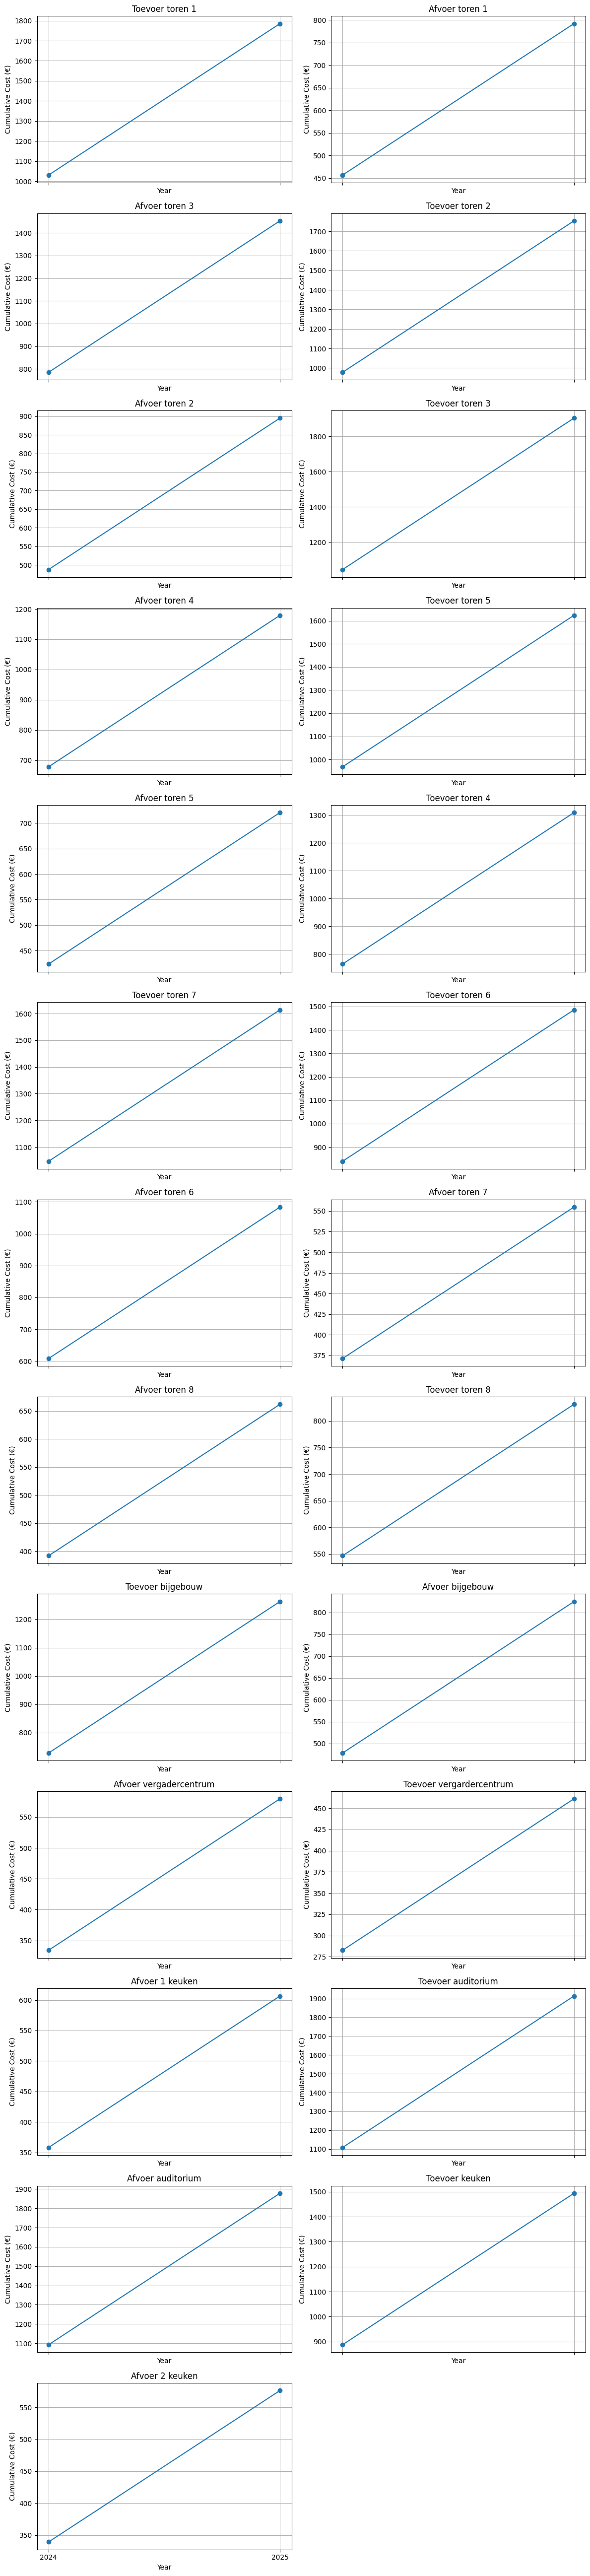

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# 1) Load & aggregate your kWh data
df = preprocess_cumulative_data(freq='D')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 2) Your previously computed baseline_means dict and unit price
#    e.g. baseline_means = {'Toevoer toren 1': 120.5, 'Afvoer toren 1': 98.3, ...}
price_per_kwh = 0.30  # € per kWh

# 3) Define train_end and 5-year post-train window
train_end_dt = pd.to_datetime("2024-06-04")
years = 5
end_dt = train_end_dt + pd.DateOffset(years=years)

# 4) Filter to post-train period and index by timestamp
period_df = (
    df[(df['timestamp'] > train_end_dt) & (df['timestamp'] <= end_dt)]
    .set_index('timestamp')
)

# 5) Compute daily excess cost per series
actual_daily = period_df[list(baseline_means.keys())] * price_per_kwh
baseline_daily = pd.DataFrame(
    {s: baseline_means[s] * price_per_kwh for s in baseline_means},
    index=period_df.index
)
excess_daily = (actual_daily - baseline_daily).clip(lower=0)

# 6) Aggregate by calendar year, then compute cumulative sums
excess_by_year = excess_daily.groupby(excess_daily.index.year).sum()
cum_excess_by_year = excess_by_year.cumsum()

# 7) Plot per series: one subplot each, years on x-axis
series_list = list(baseline_means.keys())
n = len(series_list)
cols = 2
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), sharex=True)
axes = axes.flatten()

# x-axis values are the calendar years
years_idx = cum_excess_by_year.index

for ax, series in zip(axes, series_list):
    ax.plot(years_idx, cum_excess_by_year[series], marker='o')
    ax.set_title(series)
    ax.set_xlabel('Year')
    ax.set_ylabel('Cumulative Cost (€)')
    ax.set_xticks(years_idx)
    ax.grid(True)

# Turn off unused subplots
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()